In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import rand, randn, choice, permutation
from scipy.linalg import hadamard

import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly.decomposition import parafac
from scipy import linalg

In [2]:
## Defining Measurement Matrices ##

## Returns gaussian mx(unweighted) of dimensionn m*N
def gaussian_mx(m,N): 
    A = np.random.normal(0.0, 1.0, [m, N])
    return A

def hadamard_mx(m,N):
    A = hadamard(N)
    l = permutation(np.range(N))
    return A[l[:m],:]

In [3]:
def vectorize_tl(X): ##Vectorisation for tensors
    x=X.numpy()
    x=x.reshape(-1)
    return x

def vectorize_np(X):  ##Vecorisation for numpy arrays
    x=X
    x=x.reshape(-1)
    return x

In [4]:
## Thresholding operators #########

def sparse_vect(x,s): ## s-sparse approximation
    
    x_1 = np.abs(x)
    index = np.flip(np.argsort(x_1))[:s]
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]

    return l

def sparse_vect_random(x,s):  ##Randomy selects indices to sparsify
    
    index = np.random.choice(np.shape(x)[0], s, replace=False)
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]
    
    return l

def random_low_rank_HOSVD(n,r,eps = 0.1):
    C=np.random.normal(0,1,size=r)+eps
    C=tl.tensor(C)
    C.shape
    X=C

    U=[]
    for i in range(len(n)):
        M=np.random.normal(0,1,size=(n[i],n[i]))+eps
        u,sigma,v=np.linalg.svd(M)
        U.append(u[:,0:r[i]])

    for i in range(len(n)):
        X=tl.tenalg.mode_dot(X,U[i],i)
    return X

def random_low_rank_CP(n,r,eps = 0.1):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C=np.random.normal(0,1,size=(n[i],r))+eps
        L = L + [C]
    
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    C.shape
    return C

def HOSVD_rank_app(tensor,r): ## HOSVD rank-r approximation
    
    core, factors = tl.decomposition.tucker(tensor.numpy(), r) #Decomposition function is used 
    answer = torch.tensor(tl.tucker_to_tensor([core, factors]))
    
    return answer

def CP_rank_app(tensor,r):  ## CP rank-r approximation
    
    factors = parafac(tl.tensor(tensor), rank=r)
    answer = tl.cp_to_tensor(factors)
    
    return answer

In [5]:
def TIHT_CP(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0 ##Random Initialisation

    for j in range(itr):
    
        WW = np.array(vectorize_np(vXX)) + lamda*np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_np(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = CP_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_np(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [6]:
def TIHT_HOSVD(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
    
        WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
        
    return vXX, error

In [7]:
def KZIHT(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y = np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [8]:
def KZIHT_RR(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y= np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
        
    return y,error

In [9]:
def KZIHT_HOSVD(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [10]:
def KZPT_HOSVD_RR(A,b,X,n,r, period = 1,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    t = permutation(np.arange(m))
            
    for k in range(itr): # Outer iteration for IHT updates
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
            if (j+1)%period == 0:
                WW = torch.reshape(torch.tensor(y), n)
                y = vectorize_tl(HOSVD_rank_app(WW,r))
                
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [11]:
def KZIHT_HOSVD_RR(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error


In [12]:
def KZIHT_HOSVD_DET(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = np.arange(m)
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [13]:
def row_normalised_mx(A,b):
    B = np.zeros(np.shape(A))
    c = np.zeros(np.shape(b))
    for i in range(np.shape(A)[0]):
        B[i,:] = A[i,:]/np.linalg.norm(A[i,:])
        c[i] = b[i]/np.linalg.norm(A[i,:])
    return B,c

In [147]:
"""
n = 1000
n_dim = [10,10,10]
r = [2,2,2]
itr = 250
m = 300

A_1 = np.random.normal(0.0,1.0,(n_dim[0],m))
A_2 = np.random.normal(0.0,1.0,(n_dim[1],m))
A_3 = np.random.normal(0.0,1.0,(n_dim[2],m))
A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))
A = A_4.T
#A = np.random.normal(0,1,(m,n))

X = random_low_rank_HOSVD(n_dim,r)
x = vectorize_np(X)

b = A@x
A_1,b_1 = row_normalised_mx(A,b)
"""

#np.save('x_2.npy', x)
#np.save('a_1_2.npy',A_1)
#np.save('a_2_2.npy',A_2)
#np.save('a_3_2.npy',A_3)
#np.save('a_4_2.npy',A_4)

n = 1000
n_dim = [10,10,10]
r = [2,2,2]
itr = 250
m = 300

A_4 = np.load('a_4_2.npy')
A = A_4.T

x = np.load('x_2.npy')
X = np.reshape(x,(10,10,10))

b = A@x
A_1,b_1 = row_normalised_mx(A,b)


In [148]:
y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = 250)
y_IHT_2,error_IHT_2 = TIHT_HOSVD(A_1,b_1,X,r,lamda= n/m,itr = 250)
y_KZIHT, error_KZIHT = KZIHT_HOSVD_RR(A,b,X,n,r,gamma = n/m, itr = 250)

In [149]:
error_IHT

array([1.98156002e+000, 1.38823001e+001, 1.76147019e+002, 2.68263676e+003,
       4.29436829e+004, 6.93289074e+005, 1.14149332e+007, 1.88879899e+008,
       3.12954391e+009, 5.18776678e+010, 8.60107056e+011, 1.42610159e+013,
       2.36459974e+014, 3.92074046e+015, 6.50099332e+016, 1.07793298e+018,
       1.78732673e+019, 2.96357685e+020, 4.91392422e+021, 8.14780680e+022,
       1.35099267e+024, 2.24008895e+025, 3.71430476e+026, 6.15871074e+027,
       1.02117948e+029, 1.69322374e+030, 2.80754432e+031, 4.65520588e+032,
       7.71882446e+033, 1.27986286e+035, 2.12214819e+036, 3.51874649e+037,
       5.83445441e+038, 9.67414343e+039, 1.60407546e+041, 2.65972702e+042,
       4.41010913e+043, 7.31242809e+044, 1.21247803e+046, 2.01041701e+047,
       3.33348437e+048, 5.52727018e+049, 9.16479945e+050, 1.51962083e+052,
       2.51969230e+053, 4.17791674e+054, 6.92742850e+055, 1.14864103e+057,
       1.90456849e+058, 3.15797630e+059, 5.23625922e+060, 8.68227245e+061,
       1.43961274e+063, 2

In [150]:
error_IHT_2

array([1.08426574e+000, 2.62519662e+000, 7.66563220e+000, 2.51466640e+001,
       8.76526991e+001, 3.19210438e+002, 1.21739919e+003, 4.85891885e+003,
       2.01506607e+004, 8.58949712e+004, 3.73669338e+005, 1.65385221e+006,
       7.43278606e+006, 3.38533416e+007, 1.55949961e+008, 7.25366107e+008,
       3.40311373e+009, 1.62742201e+010, 8.14651122e+010, 4.09227672e+011,
       2.05623999e+012, 1.03323630e+013, 5.19197616e+013, 2.60898095e+014,
       1.31103189e+015, 6.58808075e+015, 3.31060377e+016, 1.66363322e+017,
       8.36006416e+017, 4.20109920e+018, 2.11111829e+019, 1.06086904e+020,
       5.33107628e+020, 2.67894869e+021, 1.34621215e+022, 6.76498076e+022,
       3.39950758e+023, 1.70830370e+024, 8.58456127e+024, 4.31387468e+025,
       2.16778678e+026, 1.08935534e+027, 5.47417869e+027, 2.75085686e+028,
       1.38235945e+029, 6.94656937e+029, 3.49075518e+030, 1.75417281e+031,
       8.81498872e+031, 4.42966383e+032, 2.22599277e+033, 1.11859566e+034,
       5.62111067e+034, 2

In [151]:
error_KZIHT

array([1.01514100e+00, 9.20051977e-01, 7.50085859e-01, 5.77569276e-01,
       3.90732710e-01, 2.43768962e-01, 1.87248073e-01, 1.22472922e-01,
       8.95699355e-02, 6.58865692e-02, 5.15824879e-02, 3.87376406e-02,
       2.90124121e-02, 2.21069990e-02, 1.73051757e-02, 1.38581301e-02,
       1.07626818e-02, 8.81874964e-03, 6.88947917e-03, 5.65106148e-03,
       4.37185828e-03, 3.51140171e-03, 2.90053025e-03, 2.30254434e-03,
       1.86730420e-03, 1.57105418e-03, 1.22787457e-03, 1.02924683e-03,
       8.78291498e-04, 6.82615897e-04, 5.62554398e-04, 4.45827085e-04,
       3.70108332e-04, 2.97701779e-04, 2.36810142e-04, 2.01481402e-04,
       1.65812418e-04, 1.33527062e-04, 1.09584838e-04, 8.94192715e-05,
       7.14155235e-05, 5.85119730e-05, 4.80644704e-05, 4.09263662e-05,
       3.23081677e-05, 2.66256904e-05, 2.16178500e-05, 1.68599243e-05,
       1.33999648e-05, 1.09930245e-05, 9.29560255e-06, 7.67355658e-06,
       6.04289468e-06, 4.86310360e-06, 3.90719803e-06, 3.12176254e-06,
      

In [34]:
#######################################################
######## Analysing this Step-wise #####################
#######################################################

### First 5 iterations of IHT

vXX = torch.randn(n)*0
IHT_X = []
G_IHT_X = []
lamda = 1/m

for j in range(5):
    
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    G_IHT_X = G_IHT_X + [WW]
    
    print("Gradient  :",np.linalg.norm(WW-X)/np.linalg.norm(X))
        
    vXX = HOSVD_rank_app(WW,r)
    IHT_X = IHT_X + [vXX]

    print("Threshold :",np.linalg.norm(vXX-X)/np.linalg.norm(X))


Gradient  : 3.0205982183744244
Threshold : 1.9815600153184483
Gradient  : 16.895402588441346
Threshold : 13.882300104980517
Gradient  : 185.37189410096667
Threshold : 176.14701934565366
Gradient  : 2739.9551527193976
Threshold : 2682.636755963114
Gradient  : 43605.15220675845
Threshold : 42943.68293436173


In [35]:
### First 5 iterations of IHT (w/ normalised rows)

vXX = torch.randn(n)*0
IHTN_X = []
G_IHTN_X = []
lamda = n/m

for j in range(5):
    
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    
    G_IHTN_X = G_IHTN_X + [WW]
    print("Gradient  :",np.linalg.norm(WW-X)/np.linalg.norm(X))
    
    vXX = HOSVD_rank_app(WW,r)
    IHTN_X = IHTN_X + [vXX]

    print("Threshold :",np.linalg.norm(vXX-X)/np.linalg.norm(X))

Gradient  : 3271.1885426790395
Threshold : 2197.0212086718234
Gradient  : 20868945.092593253
Threshold : 17222355.155240193
Gradient  : 234099899057.4466
Threshold : 223499085446.92337
Gradient  : 3596710766103190.0
Threshold : 3529505419894787.5
Gradient  : 5.971158591074346e+19
Threshold : 5.899360312780203e+19


In [98]:
y = np.zeros(np.shape(x)[0]) 
KZIHT_X = []
gamma = n/m
G_KZIHT_X = []

t = permutation(np.arange(m))
            
for k in range(5): # Outer iteration for IHT updates
        
    for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[t[j],:]
        y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                        
    WW = torch.reshape(torch.tensor(y), n_dim)
    
    G_KZIHT_X = G_KZIHT_X + [WW]
    print("Gradient  :",np.linalg.norm(WW-X)/np.linalg.norm(X))
    
    KZIHT_X = KZIHT_X + [y]
    y = vectorize_tl(HOSVD_rank_app(WW,r))
    
    print("Threshold :",np.linalg.norm(y-x)/np.linalg.norm(X))

Gradient  : 1.8079631126602798
Threshold : 0.8144394534973888
Gradient  : 1.6000762292562378
Threshold : 0.6872826489720313
Gradient  : 1.389029598823975
Threshold : 0.4961383340523151
Gradient  : 0.8797102499437824
Threshold : 0.3409276229987382
Gradient  : 0.599724149620828
Threshold : 0.2501917439891141


In [37]:
###########################################################
############### Angle of descent for the iterates ######### 
###########################################################

angles_IHT = []
angles_KZIHT = []

m = np.shape(A)[0]

n = 1000
n_dim = np.shape(X)
x = np.ravel(X)

gamma = n/m
lamda = 1/m
    
y = np.zeros(np.shape(x)[0])    
t = permutation(np.arange(m))
            
for k in range(10): # Outer iteration for IHT updates
    
    y_prev = y - x    ## previous iteration
        
    for j in range(m): #Inner iteration for Kaczmarz updates
            
        a = A[t[j],:]
        y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
    
    u = y - x         ## the one that is thresholded                      
    WW = torch.reshape(torch.tensor(y), n_dim)
    y = vectorize_tl(HOSVD_rank_app(WW,r))
    v = y - x         ## post thresholding 
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_KZIHT = angles_KZIHT + [angle]
    

X_ravel = x
    
vXX = torch.randn(n)*0

for j in range(10):
    
    y_prev = (vectorize_tl(vXX)) - x
    WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(A.T, (b - np.matmul(A, np.array(vectorize_tl(vXX)))))
    u = WW - x  
    WW = torch.reshape(torch.tensor(WW), n_dim)
    vXX = HOSVD_rank_app(WW,r)
    v = (vectorize_tl(vXX)) - x
    
    angle = u.T@v/(np.linalg.norm(v)*np.linalg.norm(y_prev))
    angles_IHT = angles_IHT + [angle]

In [38]:
angles_IHT

[1.8107310223954671,
 7.002713613857714,
 12.688562687716198,
 15.229608311107196,
 16.008008624938203,
 16.14414596507773,
 16.464896962318424,
 16.54673714994655,
 16.568962221666833,
 16.576750267475575]

In [39]:
angles_KZIHT

[0.8192065407317298,
 0.7451290984085306,
 0.6754075172990714,
 0.7224417201906711,
 0.7421719945709011,
 0.744518208867347,
 0.7503315593194871,
 0.7593124223437144,
 0.7687154527245539,
 0.7750707311111696]

In [44]:
######## Analysing Angles ################
######## Coherence between A (measurement mx) and signal x #########

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(x))/(np.linalg.norm(A[i,:])*np.linalg.norm(x))
    #print(ang)
    ang_1 = ang_1 + [ang]

In [45]:
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

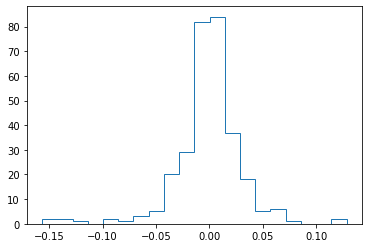

In [46]:
plt.stairs(hist, bins)

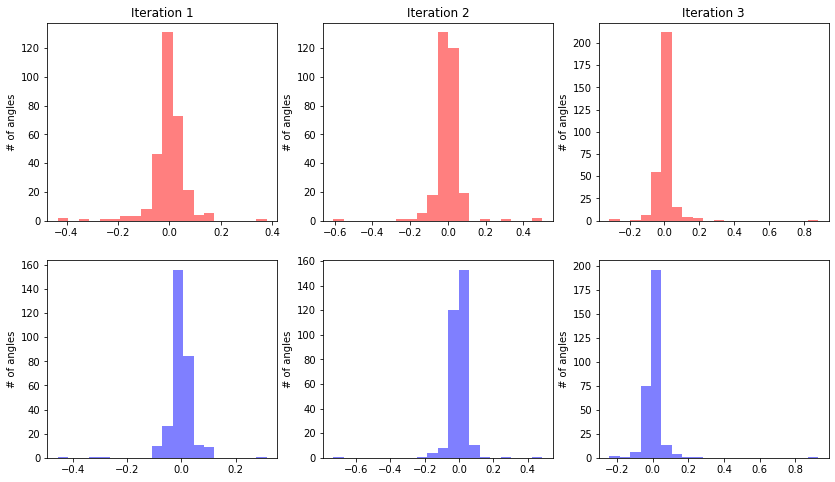

In [96]:
############### Angle of the iterates ######################## 

fig, axs = plt.subplots(2, 3)

fig.set_figheight(8)
fig.set_figwidth(14)

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_IHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_IHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 0].hist(ang_1, bins, alpha = 0.5, color = 'r')
axs[0, 0].set_title('Iteration 1')

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(IHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(IHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 0].hist(ang_1, bins, alpha = 0.5, color = 'b')
#axs[1, 0].set_title('Iteration 1')


ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_IHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_IHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 1].hist(ang_1, bins, alpha = 0.5, color = 'r')
axs[0, 1].set_title('Iteration 2')

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(IHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(IHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 1].hist(ang_1, bins, alpha = 0.5, color = 'b')
#axs[1, 1].set_title('Iteration 2')

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_IHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_IHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 2].hist(ang_1, bins, alpha = 0.5, color = 'r')
axs[0, 2].set_title('Iteration 3')

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(IHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(IHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 2].hist(ang_1, bins, alpha = 0.5, color = 'b')
#axs[1, 2].set_title('Iteration 3')

for ax in axs.flat:
    ax.set( ylabel='# of angles')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()

plt.savefig('hist_IHT.png')

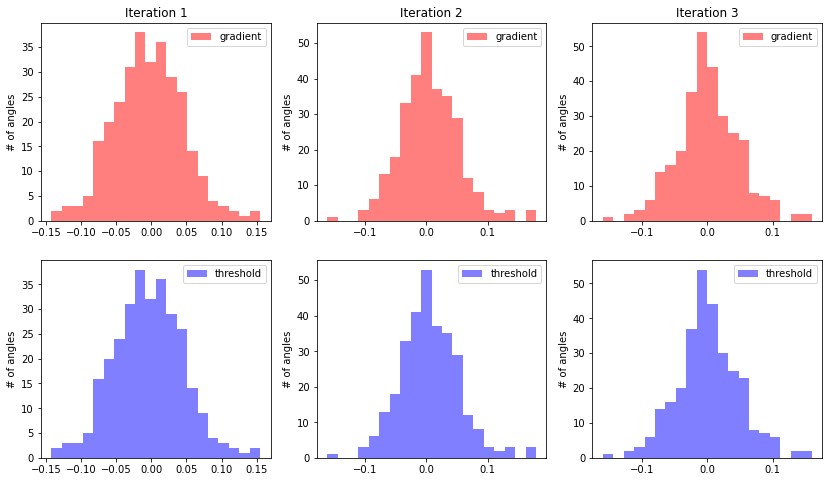

In [195]:
############### Angle of the iterates ######################## 

fig, axs = plt.subplots(2, 3)

fig.set_figheight(8)
fig.set_figwidth(14)

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_KZIHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_KZIHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 0].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "gradient")
axs[0, 0].set_title('Iteration 1')
axs[0, 0].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(KZIHT_X[0]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(KZIHT_X[0]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 0].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "threshold")
axs[1, 0].legend(loc="upper right")
#axs[1, 0].set_title('Iteration 1')


ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_KZIHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_KZIHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 1].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "gradient")
axs[0, 1].set_title('Iteration 2')
axs[0, 1].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(KZIHT_X[1]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(KZIHT_X[1]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 1].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "threshold")
#axs[1, 1].set_title('Iteration 2')
axs[1, 1].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(G_KZIHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(G_KZIHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[0, 2].hist(ang_1, bins, alpha = 0.5, color = 'r',label = "gradient")
axs[0, 2].set_title('Iteration 3')
axs[0, 2].legend(loc="upper right")

ang_1 = []
for i in range(300):
    ang = A[i,:]@(np.ravel(np.array(KZIHT_X[2]))-x)/(np.linalg.norm(A[i,:])*np.linalg.norm(np.ravel(np.array(KZIHT_X[2]))-x))
    ang_1 = ang_1 + [ang]
    
hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)

axs[1, 2].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "threshold")
#axs[1, 2].set_title('Iteration 3')
axs[1, 2].legend(loc="upper right")

for ax in axs.flat:
    ax.set( ylabel='# of angles')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()

plt.savefig('hist_IHT.png')

In [253]:
##################################################################
###### Randomised Average Kaczmarz ##############################
#################################################################

### Functions defined to drop high and low values from an array

def index_coherent(a, number = 5):

    a_abs = np.abs(a)
    res = sorted(range(len(a_abs)), key = lambda sub: a_abs[sub])[-number:]
    return res

def TIHT_HOSVD_incoh(AA,yy,X,r,lamda = 1, itr = 100, num = 2): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
        
        ang_1 = []
        
        for i in range(300):
            ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
            ang_1 = ang_1 + [ang]
                           
        remove_row = index_coherent(np.abs(ang_1), number = num)
        A_1 = np.delete(AA,remove_row,axis = 0)
        y_1 = np.delete(yy,remove_row,axis = 0)
    
        WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
          
    return vXX, error

def TIHT_HOSVD_adap(AA,yy,X,r,lamda = 1, itr = 100, num_max = 2, incoh_th = 0.1):
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n)*0

    for j in range(itr):
        
        ang_1 = []
        ele = 0
        
        for i in range(300):
            ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
            ang_1 = ang_1 + [ang]
            if np.abs(ang) > incoh_th:
                ele = ele + 1
            
        num_1 = min(ele,num_max)
        #print(num_1)
        
        remove_row = index_coherent(np.abs(ang_1), number = num_1)
        
        A_1 = np.delete(AA,remove_row,axis = 0)
        y_1 = np.delete(yy,remove_row,axis = 0)
    
        WW = np.array(vectorize_tl(vXX)) + (m/(m-num_1))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
          
    return vXX, error

In [254]:
y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = 250)

In [255]:
error_IHT

array([1.98156002e+000, 1.38823001e+001, 1.76147019e+002, 2.68263676e+003,
       4.29436829e+004, 6.93289074e+005, 1.14149332e+007, 1.88879899e+008,
       3.12954391e+009, 5.18776678e+010, 8.60107056e+011, 1.42610159e+013,
       2.36459974e+014, 3.92074046e+015, 6.50099332e+016, 1.07793298e+018,
       1.78732673e+019, 2.96357685e+020, 4.91392422e+021, 8.14780680e+022,
       1.35099267e+024, 2.24008895e+025, 3.71430476e+026, 6.15871074e+027,
       1.02117948e+029, 1.69322374e+030, 2.80754432e+031, 4.65520588e+032,
       7.71882446e+033, 1.27986286e+035, 2.12214819e+036, 3.51874649e+037,
       5.83445441e+038, 9.67414343e+039, 1.60407546e+041, 2.65972702e+042,
       4.41010913e+043, 7.31242809e+044, 1.21247803e+046, 2.01041701e+047,
       3.33348437e+048, 5.52727018e+049, 9.16479945e+050, 1.51962083e+052,
       2.51969230e+053, 4.17791674e+054, 6.92742850e+055, 1.14864103e+057,
       1.90456849e+058, 3.15797630e+059, 5.23625922e+060, 8.68227245e+061,
       1.43961274e+063, 2

In [256]:
y_IHT_incoh,error_IHT_incoh = TIHT_HOSVD_incoh(A,b,X,r,lamda=1/m,itr = 250,num = 20)

In [257]:
error_IHT_incoh

array([1.22578626e+00, 1.88127421e+00, 1.65880002e+00, 1.86802894e+00,
       2.17864149e+00, 2.88237692e+00, 2.56455752e+00, 2.66935620e+00,
       3.42283389e+00, 2.97632525e+00, 2.69095389e+00, 2.47464560e+00,
       2.28107294e+00, 2.48761249e+00, 3.93898202e+00, 4.13137883e+00,
       5.92503991e+00, 5.61615019e+00, 6.92846504e+00, 6.01345514e+00,
       6.36693198e+00, 5.37633830e+00, 4.26892363e+00, 4.59605866e+00,
       4.59467289e+00, 4.10417966e+00, 3.10628137e+00, 2.66551649e+00,
       2.31679717e+00, 2.10260503e+00, 1.88097933e+00, 1.65092374e+00,
       1.45299992e+00, 1.41547550e+00, 1.18177915e+00, 1.14930585e+00,
       9.44421783e-01, 8.46264171e-01, 9.97423485e-01, 8.39856945e-01,
       7.35923559e-01, 5.61153390e-01, 4.17814304e-01, 3.21290949e-01,
       2.63981962e-01, 2.12573487e-01, 1.77674674e-01, 1.48578959e-01,
       1.25085242e-01, 1.05356431e-01, 9.79515213e-02, 8.55735181e-02,
       6.95072842e-02, 6.02218717e-02, 5.08983198e-02, 4.59410946e-02,
      

In [278]:
y_IHT_adap,error_IHT_adap = TIHT_HOSVD_adap(A,b,X,r,lamda=1/m,itr = 250,num_max = 20,incoh_th = 0.045)

In [279]:
error_IHT_adap

array([1.22578626e+00, 1.88127421e+00, 1.65880002e+00, 1.86802894e+00,
       2.17864149e+00, 2.88237692e+00, 2.56455752e+00, 2.66935620e+00,
       3.42283389e+00, 2.97632525e+00, 2.69095389e+00, 2.47464560e+00,
       2.28107294e+00, 2.48761249e+00, 3.93898202e+00, 4.13137883e+00,
       5.92503991e+00, 5.61615019e+00, 6.92846504e+00, 6.01345514e+00,
       6.36693198e+00, 5.37633830e+00, 4.26892363e+00, 4.59605866e+00,
       4.59467289e+00, 4.10417966e+00, 3.10628137e+00, 2.66551649e+00,
       2.31679717e+00, 2.10260503e+00, 1.88097933e+00, 1.65092374e+00,
       1.45299992e+00, 1.41547550e+00, 1.18177915e+00, 1.14930585e+00,
       9.44421783e-01, 8.46264171e-01, 9.97423485e-01, 8.39856945e-01,
       7.35923559e-01, 5.61153390e-01, 4.17814304e-01, 3.21290949e-01,
       2.62900504e-01, 2.20939630e-01, 1.77585892e-01, 1.56998347e-01,
       1.26228527e-01, 1.13001549e-01, 9.51630170e-02, 8.39233496e-02,
       7.05453838e-02, 5.98580104e-02, 5.18856648e-02, 4.56221057e-02,
      

In [307]:
AA = A
yy = b
num = 20
n = np.shape(X)
X_ravel = np.ravel(X)
lamda = 1/m

num_max = 20
incoh_th = 0.045
    
error = np.zeros(itr)
error_1 = np.zeros(itr)
error_2 = np.zeros(itr)
    
vXX = torch.randn(n)*0
vXX_2 = torch.randn(n)*0
vXX_3 = torch.randn(n)*0

for j in range(105):

    ang_1 = []
    
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
        ang_1 = ang_1 + [ang]
                           
    remove_row = index_coherent(np.abs(ang_1), number = num)
    A_1 = np.delete(AA,remove_row,axis = 0)
    y_1 = np.delete(yy,remove_row,axis = 0)
    
    WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = HOSVD_rank_app(WW,r)
    
    WW_2 = np.array(vectorize_tl(vXX_2)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX_2)))))
    WW_2 = torch.reshape(torch.tensor(WW_2), n)
    vXX_2 = HOSVD_rank_app(WW_2,r)
    
    ang_1 = []
    ele = 0
        
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX_3)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX_3)-x)))
        ang_1 = ang_1 + [ang]
        if np.abs(ang) > incoh_th:
            ele = ele + 1
            
    num_1 = min(ele,num_max)
    remove_row_2 = index_coherent(np.abs(ang_1), number = num_1)
    
    A_2 = np.delete(AA,remove_row_2,axis = 0)
    y_2 = np.delete(yy,remove_row_2,axis = 0)
                
    WW_3 = np.array(vectorize_tl(vXX_3)) + (m/(m-num_1))*lamda* np.matmul(A_2.T, (y_2 - np.matmul(A_2, np.array(vectorize_tl(vXX_3)))))
    WW_3 = torch.reshape(torch.tensor(WW_3), n)
    vXX_3 = HOSVD_rank_app(WW_3,r)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
    error_1[j] = np.linalg.norm(vectorize_tl(vXX_2)- X_ravel)/np.linalg.norm(X_ravel)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    print("incoh:",error[j])
    print("normal:",error_1[j])
    print("adap:", error_2[j])

incoh: 1.2257862585672097
normal: 1.9815600153184483
adap: 1.2257862585672097
incoh: 1.881274207134894
normal: 13.882300104980517
adap: 1.881274207134894
incoh: 1.65880002498789
normal: 176.14701934565366
adap: 1.65880002498789
incoh: 1.8680289375282202
normal: 2682.636755963114
adap: 1.8680289375282202
incoh: 2.178641492656313
normal: 42943.68293436173
adap: 2.178641492656313
incoh: 2.882376920543902
normal: 693289.0738412134
adap: 2.882376920543902
incoh: 2.564557522365648
normal: 11414933.16834155
adap: 2.564557522365648
incoh: 2.6693561967205683
normal: 188879898.72028762
adap: 2.6693561967205683
incoh: 3.4228338884033507
normal: 3129543906.3287983
adap: 3.4228338884033507
incoh: 2.976325247049487
normal: 51877667786.31247
adap: 2.976325247049487
incoh: 2.69095389007468
normal: 860107055541.7267
adap: 2.69095389007468
incoh: 2.47464560069477
normal: 14261015913170.537
adap: 2.47464560069477
incoh: 2.2810729443445945
normal: 236459974333879.4
adap: 2.2810729443445945
incoh: 2.487612

incoh: 0.00018621511986055894
normal: 2.282819271391845e+125
adap: 5.8622406115843613e-05
incoh: 0.00015383586902570665
normal: 3.785156162687934e+126
adap: 5.153175445695154e-05


In [311]:
pd.DataFrame(np.concatenate(([error],[error_2],[error_1]),axis = 0)[:,:100].T, columns = ["Incoherence Clipping","Adapted Clipping","Normal"])

,Incoherence Clipping,Adapted Clipping,Normal
0,1.225786,1.225786,1.981560e+00
1,1.881274,1.881274,1.388230e+01
2,1.658800,1.658800,1.761470e+02
3,1.868029,1.868029,2.682637e+03
4,2.178641,2.178641,4.294368e+04
...,...,...,...
95,0.000429,0.000163,3.995520e+115
96,0.000382,0.000144,6.624996e+116
97,0.000358,0.000132,1.098495e+118
98,0.000321,0.000117,1.821420e+119


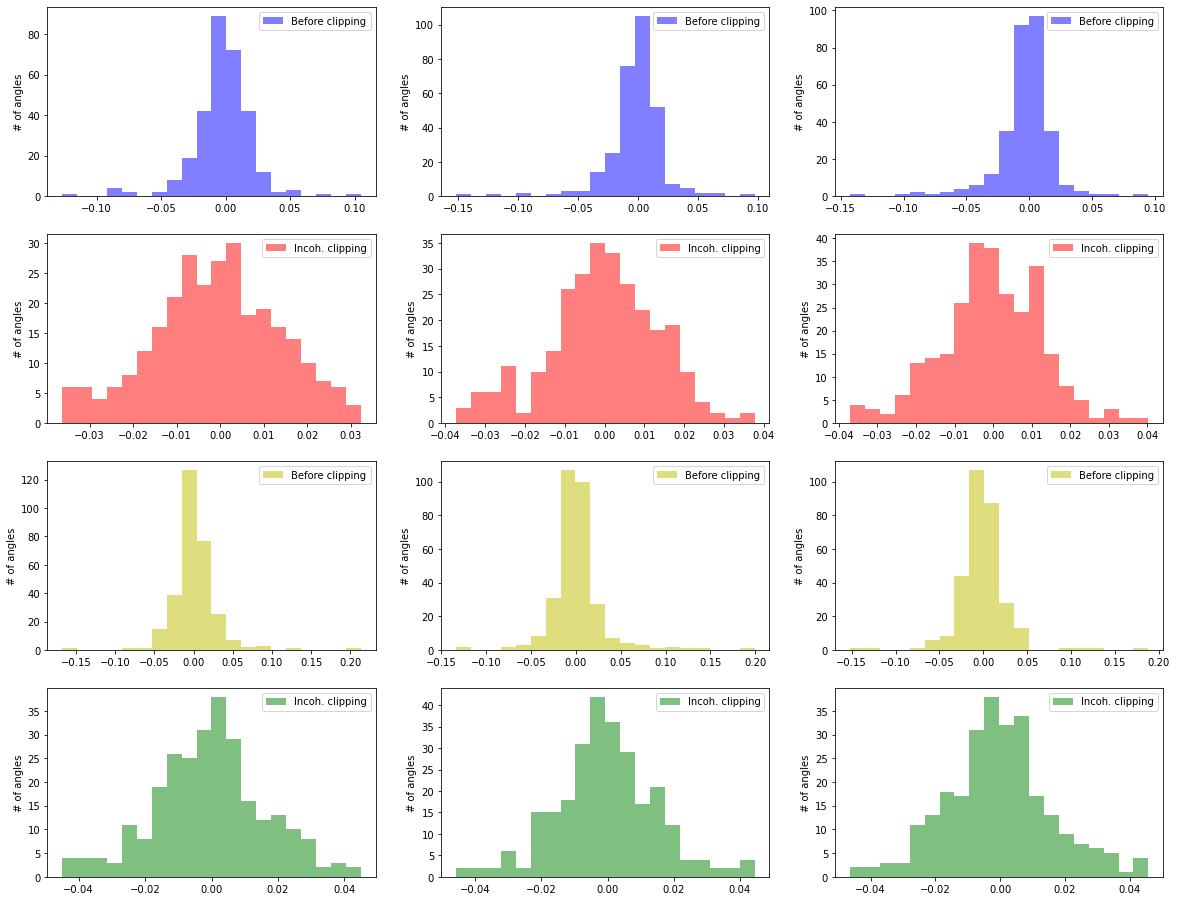

In [319]:
###############################################################
#### Understanding how the row selection works for: ###########
#### a) Incoherence clipping ##################################
#### b) Adaptive clipping #####################################

#### Iterations 100-105 
fig, axs = plt.subplots(4, 3)
fig.set_figheight(16)
fig.set_figwidth(20)

AA = A
yy = b
num = 20
n = np.shape(X)
X_ravel = np.ravel(X)
lamda = 1/m

num_max = 20
incoh_th = 0.045
    
error = np.zeros(itr)
error_1 = np.zeros(itr)
error_2 = np.zeros(itr)
    
vXX = torch.randn(n)*0
vXX_2 = torch.randn(n)*0
vXX_3 = torch.randn(n)*0

for j in range(103):

    ang_1 = []
    
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX)-x)))
        ang_1 = ang_1 + [ang]
                           
    remove_row = index_coherent(np.abs(ang_1), number = num)
    
    if j >=100:
        
        hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)
        axs[0, j-100].hist(ang_1, bins, alpha = 0.5, color = 'b',label = "Before clipping")
        #axs[1, 2].set_title('Iteration 3')
        axs[0, j-100].legend(loc="upper right")
        
        hist, bins = np.histogram(np.delete(ang_1,remove_row,axis=0), bins=20, range=None, density=None, weights=None)
        axs[1, j-100].hist(np.delete(ang_1,remove_row,axis=0), bins, alpha = 0.5, color = 'r',label = "Incoh. clipping")
        axs[1, j-100].legend(loc="upper right")
        
    
    A_1 = np.delete(AA,remove_row,axis = 0)
    y_1 = np.delete(yy,remove_row,axis = 0)
    
    WW = np.array(vectorize_tl(vXX)) + (m/(m-num))*lamda* np.matmul(A_1.T, (y_1 - np.matmul(A_1, np.array(vectorize_tl(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = HOSVD_rank_app(WW,r)
    
    WW_2 = np.array(vectorize_tl(vXX_2)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX_2)))))
    WW_2 = torch.reshape(torch.tensor(WW_2), n)
    vXX_2 = HOSVD_rank_app(WW_2,r)
    
    ang_1 = []
    ele = 0
        
    for i in range(300):
        ang = AA[i,:]@(np.ravel(vectorize_tl(vXX_3)-x)/(np.linalg.norm(AA[i,:])*np.linalg.norm(vectorize_tl(vXX_3)-x)))
        ang_1 = ang_1 + [ang]
        if np.abs(ang) > incoh_th:
            ele = ele + 1
            
    num_1 = min(ele,num_max)
    remove_row_2 = index_coherent(np.abs(ang_1), number = num_1)
    
    if j >=100:
        
        hist, bins = np.histogram(np.array(ang_1), bins=20, range=None, density=None, weights=None)
        axs[2, j-100].hist(ang_1, bins, alpha = 0.5, color = 'y',label = "Before clipping")
        #axs[1, 2].set_title('Iteration 3')
        axs[2, j-100].legend(loc="upper right")
        
        hist, bins = np.histogram(np.delete(ang_1,remove_row_2,axis=0), bins=20, range=None, density=None, weights=None)
        axs[3, j-100].hist(np.delete(ang_1,remove_row,axis=0), bins, alpha = 0.5, color = 'g',label = "Incoh. clipping")
        axs[3, j-100].legend(loc="upper right")
    
    A_2 = np.delete(AA,remove_row_2,axis = 0)
    y_2 = np.delete(yy,remove_row_2,axis = 0)
                
    WW_3 = np.array(vectorize_tl(vXX_3)) + (m/(m-num_1))*lamda* np.matmul(A_2.T, (y_2 - np.matmul(A_2, np.array(vectorize_tl(vXX_3)))))
    WW_3 = torch.reshape(torch.tensor(WW_3), n)
    vXX_3 = HOSVD_rank_app(WW_3,r)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)/np.linalg.norm(X_ravel)
    error_1[j] = np.linalg.norm(vectorize_tl(vXX_2)- X_ravel)/np.linalg.norm(X_ravel)
    error_2[j] = np.linalg.norm(vectorize_tl(vXX_3)- X_ravel)/np.linalg.norm(X_ravel)
    
    for ax in axs.flat:
        ax.set( ylabel='# of angles')